## Prepare Library

In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch
import torchmetrics
from torchmetrics.classification.accuracy import Accuracy
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.autograd import Variable 
from tqdm.auto import tqdm
from scipy import integrate
from model import LSTM
from random import sample
import torch.nn as nn
import scikitplot as skplt


## Prepare CPU

In [19]:
print(torch.__version__ )
print(torch.version.cuda)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2.1.1+cpu
None
False


## Dataset

In [20]:
Index = ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Channel6']

Data_path = 'D:/Workspace/TENG-Signal-Classification/dataset/preprocessed'

cases = os.listdir(Data_path)

random.shuffle(cases)

## Load data

In [21]:
test_set = cases[:40]

valid_set = cases[40:80]

train_set = cases[80:]

print('lenght of train set:', len(train_set))
print('lenght of valid set:', len(valid_set))
print('valid set:', valid_set)
print('lenght of test set:', len(test_set))
print('test set:', test_set)

lenght of train set: 220
lenght of valid set: 40
valid set: ['C3_10', 'C6_1', 'C5_3', 'C1_2', 'C6_33', 'C3_23', 'C1_4', 'C1_13', 'C5_29', 'C6_18', 'C6_22', 'C6_6', 'C5_26', 'C5_41', 'C3_3', 'C2_2', 'C6_29', 'C5_14', 'C5_19', 'C5_40', 'C5_43', 'C3_30', 'C6_45', 'C6_3', 'C1_48', 'C6_5', 'C3_8', 'C4_5', 'C5_38', 'C6_49', 'C3_14', 'C1_38', 'C2_14', 'C1_30', 'C6_48', 'C1_3', 'C6_25', 'C2_21', 'C3_13', 'C1_27']
lenght of test set: 40
test set: ['C4_44', 'C1_6', 'C1_24', 'C5_42', 'C4_1', 'C3_20', 'C2_9', 'C4_13', 'C5_35', 'C5_15', 'C4_17', 'C2_26', 'C1_29', 'C4_33', 'C6_42', 'C4_32', 'C3_12', 'C1_35', 'C6_20', 'C2_7', 'C3_1', 'C6_16', 'C2_15', 'C6_41', 'C5_18', 'C1_37', 'C3_40', 'C6_10', 'C2_17', 'C1_43', 'C2_4', 'C4_38', 'C2_12', 'C1_19', 'C4_11', 'C3_33', 'C5_49', 'C6_44', 'C2_46', 'C2_42']


In [22]:
x_train_data = [] 
y_train_data = []
x_valid_data = []
y_valid_data = []
x_test_data = []
y_test_data = []

print('| loading train set data..... |')
for case in train_set:
    DATA = {}
    label = case.split('_')[0]
    #   Read csv
    file = case + '.csv'
    data = pd.read_csv(Data_path + '/' + case + '/' + file, usecols = Index)
    #   Convert lable into int
    Encode_label = {
            'C1': 0,
            'C2': 1,
            'C3': 2,
            'C4': 3,
            'C5': 4,
            'C6': 5, 
    }
    entropy = pd.value_counts(data['Channel1']) / len(data['Channel1'])
    DATA['C1'] = [sum(data['Channel1'].to_numpy()),np.max((data['Channel1'].to_numpy())),np.min((data['Channel1'].to_numpy())),np.mean((data['Channel1'].to_numpy())),np.std((data['Channel1'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel1'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel2']) / len(data['Channel2'])
    DATA['C2'] = [sum(data['Channel2'].to_numpy()),np.max((data['Channel2'].to_numpy())),np.min((data['Channel2'].to_numpy())),np.mean((data['Channel2'].to_numpy())),np.std((data['Channel2'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel2'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel3']) / len(data['Channel3'])
    DATA['C3'] = [sum(data['Channel3'].to_numpy()),np.max((data['Channel3'].to_numpy())),np.min((data['Channel3'].to_numpy())),np.mean((data['Channel3'].to_numpy())),np.std((data['Channel3'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel3'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel4']) / len(data['Channel4'])
    DATA['C4'] = [sum(data['Channel4'].to_numpy()),np.max((data['Channel4'].to_numpy())),np.min((data['Channel4'].to_numpy())),np.mean((data['Channel4'].to_numpy())),np.std((data['Channel4'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel4'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel5']) / len(data['Channel5'])
    DATA['C5'] = [sum(data['Channel5'].to_numpy()),np.max((data['Channel5'].to_numpy())),np.min((data['Channel5'].to_numpy())),np.mean((data['Channel5'].to_numpy())),np.std((data['Channel5'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel5'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel6']) / len(data['Channel6'])
    DATA['C6'] = [sum(data['Channel6'].to_numpy()),np.max((data['Channel6'].to_numpy())),np.min((data['Channel6'].to_numpy())),np.mean((data['Channel6'].to_numpy())),np.std((data['Channel6'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel6'].to_numpy())))**2]
    # x_train_data.append(data)
    x_train_data.append(pd.DataFrame.from_dict(DATA, orient='index').T)
    y_train_data.append(Encode_label[label])
print('| done |')

print('| loading valid set data..... |')
for case in valid_set:
    DATA = {}
    label = case.split('_')[0]
    #   Read csv
    file = case + '.csv'
    data = pd.read_csv(Data_path + '/' + case + '/' + file, usecols = Index)
    #   Convert lable into int
    Encode_label = {
            'C1': 0,
            'C2': 1,
            'C3': 2,
            'C4': 3,
            'C5': 4,
            'C6': 5, 
    }
    entropy = pd.value_counts(data['Channel1']) / len(data['Channel1'])
    DATA['C1'] = [sum(data['Channel1'].to_numpy()),np.max((data['Channel1'].to_numpy())),np.min((data['Channel1'].to_numpy())),np.mean((data['Channel1'].to_numpy())),np.std((data['Channel1'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel1'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel2']) / len(data['Channel2'])
    DATA['C2'] = [sum(data['Channel2'].to_numpy()),np.max((data['Channel2'].to_numpy())),np.min((data['Channel2'].to_numpy())),np.mean((data['Channel2'].to_numpy())),np.std((data['Channel2'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel2'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel3']) / len(data['Channel3'])
    DATA['C3'] = [sum(data['Channel3'].to_numpy()),np.max((data['Channel3'].to_numpy())),np.min((data['Channel3'].to_numpy())),np.mean((data['Channel3'].to_numpy())),np.std((data['Channel3'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel3'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel4']) / len(data['Channel4'])
    DATA['C4'] = [sum(data['Channel4'].to_numpy()),np.max((data['Channel4'].to_numpy())),np.min((data['Channel4'].to_numpy())),np.mean((data['Channel4'].to_numpy())),np.std((data['Channel4'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel4'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel5']) / len(data['Channel5'])
    DATA['C5'] = [sum(data['Channel5'].to_numpy()),np.max((data['Channel5'].to_numpy())),np.min((data['Channel5'].to_numpy())),np.mean((data['Channel5'].to_numpy())),np.std((data['Channel5'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel5'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel6']) / len(data['Channel6'])
    DATA['C6'] = [sum(data['Channel6'].to_numpy()),np.max((data['Channel6'].to_numpy())),np.min((data['Channel6'].to_numpy())),np.mean((data['Channel6'].to_numpy())),np.std((data['Channel6'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel6'].to_numpy())))**2]
    # x_valid_data.append(data)
    x_valid_data.append(pd.DataFrame.from_dict(DATA, orient='index').T)
    y_valid_data.append(Encode_label[label])
print('| done |')

print('| loading test set data..... |')
for case in test_set:
    DATA = {}
    label = case.split('_')[0]
    #   Read csv
    file = case + '.csv'
    data = pd.read_csv(Data_path + '/' + case + '/' + file, usecols = Index)
    #   Convert lable into int
    Encode_label = {
            'C1': 0,
            'C2': 1,
            'C3': 2,
            'C4': 3,
            'C5': 4,
            'C6': 5, 
    }
    entropy = pd.value_counts(data['Channel1']) / len(data['Channel1'])
    DATA['C1'] = [sum(data['Channel1'].to_numpy()),np.max((data['Channel1'].to_numpy())),np.min((data['Channel1'].to_numpy())),np.mean((data['Channel1'].to_numpy())),np.std((data['Channel1'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel1'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel2']) / len(data['Channel2'])
    DATA['C2'] = [sum(data['Channel2'].to_numpy()),np.max((data['Channel2'].to_numpy())),np.min((data['Channel2'].to_numpy())),np.mean((data['Channel2'].to_numpy())),np.std((data['Channel2'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel2'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel3']) / len(data['Channel3'])
    DATA['C3'] = [sum(data['Channel3'].to_numpy()),np.max((data['Channel3'].to_numpy())),np.min((data['Channel3'].to_numpy())),np.mean((data['Channel3'].to_numpy())),np.std((data['Channel3'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel3'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel4']) / len(data['Channel4'])
    DATA['C4'] = [sum(data['Channel4'].to_numpy()),np.max((data['Channel4'].to_numpy())),np.min((data['Channel4'].to_numpy())),np.mean((data['Channel4'].to_numpy())),np.std((data['Channel4'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel4'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel5']) / len(data['Channel5'])
    DATA['C5'] = [sum(data['Channel5'].to_numpy()),np.max((data['Channel5'].to_numpy())),np.min((data['Channel5'].to_numpy())),np.mean((data['Channel5'].to_numpy())),np.std((data['Channel5'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel5'].to_numpy())))**2]
    entropy = pd.value_counts(data['Channel6']) / len(data['Channel6'])
    DATA['C6'] = [sum(data['Channel6'].to_numpy()),np.max((data['Channel6'].to_numpy())),np.min((data['Channel6'].to_numpy())),np.mean((data['Channel6'].to_numpy())),np.std((data['Channel6'].to_numpy())),sum(np.log2(entropy) * entropy * (-1)),(np.mean(np.abs(data['Channel6'].to_numpy())))**2]
    # x_test_data.append(data)
    x_test_data.append(pd.DataFrame.from_dict(DATA, orient='index').T)
    y_test_data.append(Encode_label[label])
print('| done |')

ss = StandardScaler()
mm = MinMaxScaler()

X_train_tensors = []
Y_train_tensors = []
X_valid_tensors = []
Y_valid_tensors = []
X_test_tensors = []
Y_test_tensors = []


print('| train set data to tensor..... |')
## To tensors
for i in range(len(train_set)):
    X = x_train_data[i]
    Y = y_train_data[i]
    X_ss = ss.fit_transform(X)
    
    X_tensors = torch.Tensor(X_ss)
    Y_tensors = torch.tensor(Y)

    X_train_tensors.append(X_tensors.to(device))
    Y_train_tensors.append(Y_tensors.to(device))
print('| done |')

print('| valid data to tensor..... |')
for i in range(len(valid_set)):
    X = x_valid_data[i]
    Y = y_valid_data[i]
    X_ss = ss.fit_transform(X)
    
    X_tensors = torch.Tensor(X_ss)
    Y_tensors = torch.tensor(Y)

    X_valid_tensors.append(X_tensors.to(device))
    Y_valid_tensors.append(Y_tensors.to(device))
print('| done |')

print('| test data to tensor..... |')
for i in range(len(test_set)):
    X = x_test_data[i]
    Y = y_test_data[i]
    X_ss = ss.fit_transform(X)
    
    X_tensors = torch.Tensor(X_ss)
    Y_tensors = torch.tensor(Y)

    X_test_tensors.append(X_tensors.to(device))
    Y_test_tensors.append(Y_tensors.to(device))
print('| done |')

| loading train set data..... |
| done |
| loading valid set data..... |
| done |
| loading test set data..... |
| done |
| train set data to tensor..... |
| done |
| valid data to tensor..... |
| done |
| test data to tensor..... |
| done |


## Training (LSTM)

In [23]:
num_epochs = 200
learning_rate = 5e-4

n_features = len(Index) #number of features
n_hidden = 64 #number of features in hidden state
n_layers = 2 #number of stacked lstm layers
n_classes = 6 #number of output classes 
dropout = 0.2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
lstm = LSTM(n_features, n_classes, n_hidden, n_layers, dropout, device) #our lstm class
lstm.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 
accuracy = Accuracy(task="multiclass", num_classes=6)
train_loss = []
train_acc = []

trainer_path = 'D:/Workspace/TENG-Signal-Classification/trainer/'
    
valid_loss = []

valid_acc = []                       

to_one_hot = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]

for epoch in tqdm(range(num_epochs)):
    l = []
    pre = []
    mix = []
    
    for index, case in enumerate(train_set):
        rand_index = random.randint(0,len(train_set) - 1)
        x1 = X_train_tensors[index]
        x2 = X_train_tensors[rand_index]
        label1 = Y_train_tensors[index]
        label2 = Y_train_tensors[rand_index]
        one_hot1 = to_one_hot[label1]
        one_hot2 = to_one_hot[label2]
        
        random_noise = torch.Tensor(0.05 * np.random.randn(7,6))
        
        lam = 0.7
        x_mixed_up = lam * x1 + (1 - lam) * x2 + random_noise
        y_mixed_up = lam * torch.FloatTensor(one_hot1) + (1 - lam) * torch.FloatTensor(one_hot2)

        outputs = lstm.forward(x_mixed_up) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        step_loss = criterion(torch.unsqueeze(outputs,0), torch.unsqueeze(y_mixed_up,0).to(device))
        l.append(step_loss.item())

        mixed_up = torch.argmax(y_mixed_up)
        mix.append(mixed_up)
        prediction = torch.argmax(outputs)
        pre.append(prediction)
        step_loss.backward() #calculates the loss of the loss function
        optimizer.step() #improve from loss, i.e backprop

    acc = accuracy(torch.tensor(pre), torch.tensor(mix))
    train_acc.append(acc.item())
    loss = np.mean(l) 
    train_loss.append(loss)
    best_train_loss = min(train_loss)
    
    if epoch < 10:
        print("Epoch: %d | train loss: %1.5f, best: %1.5f | accuracy: %1.5f, best: %1.5f" % (epoch, loss, best_train_loss, acc, max(train_acc))) 
    else:
        print("Epoch: %d| train loss: %1.5f, best: %1.5f | accuracy: %1.5f, best: %1.5f" % (epoch, loss, best_train_loss, acc, max(train_acc))) 

    # if epoch % 5 == 0 or epoch == num_epochs - 1 :
    _l = []
    _pre = []
    _acc = []
    for index, case in enumerate(valid_set):

        label = Y_valid_tensors[index]
        one_hot = to_one_hot[label]
        
        outputs = lstm(X_valid_tensors[index]) #forward pass
        step_loss = criterion(torch.unsqueeze(outputs,0), torch.unsqueeze(torch.FloatTensor(one_hot),0).to(device))
        _l.append(step_loss.item())
        prediction = torch.argmax(outputs)
        
        _pre.append(prediction)
    
    _acc = accuracy(torch.tensor(_pre), torch.tensor(Y_valid_tensors)) 
    valid_acc.append(_acc.item())
    _loss = np.mean(_l)
    if  _acc >= 0.8:
        torch.save(lstm.state_dict(), trainer_path + 'epoch_' + str(epoch) +
                   '_loss_' + str(_loss) + '_acc_' + str(_acc.item() * 100) + '%' + '.pt')
    
    valid_loss.append(_loss)
    best_valid_loss = min(valid_loss)
    
    if epoch == num_epochs - 1:
        print("         | valid loss: %1.5f, best: %1.5f | accuracy: %1.5f, best: %1.5f" % (_loss, best_valid_loss, _acc, max(valid_acc))) 
    else:
        print("         | valid loss: %1.5f, best: %1.5f | accuracy: %1.5f, best: %1.5f" % (_loss, best_valid_loss, _acc, max(valid_acc)))


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.79249, best: 1.79249 | accuracy: 0.18636, best: 0.18636
         | valid loss: 1.82072, best: 1.82072 | accuracy: 0.15000, best: 0.15000
Epoch: 1 | train loss: 1.75794, best: 1.75794 | accuracy: 0.22273, best: 0.22273
         | valid loss: 1.88751, best: 1.82072 | accuracy: 0.17500, best: 0.17500
Epoch: 2 | train loss: 1.67126, best: 1.67126 | accuracy: 0.34091, best: 0.34091
         | valid loss: 1.61782, best: 1.61782 | accuracy: 0.30000, best: 0.30000
Epoch: 3 | train loss: 1.53428, best: 1.53428 | accuracy: 0.39545, best: 0.39545
         | valid loss: 1.51682, best: 1.51682 | accuracy: 0.42500, best: 0.42500
Epoch: 4 | train loss: 1.48066, best: 1.48066 | accuracy: 0.49545, best: 0.49545
         | valid loss: 1.37637, best: 1.37637 | accuracy: 0.50000, best: 0.50000
Epoch: 5 | train loss: 1.40112, best: 1.40112 | accuracy: 0.56818, best: 0.56818
         | valid loss: 1.27717, best: 1.27717 | accuracy: 0.47500, best: 0.50000
Epoch: 6 | train loss: 1.377

## Save Loss

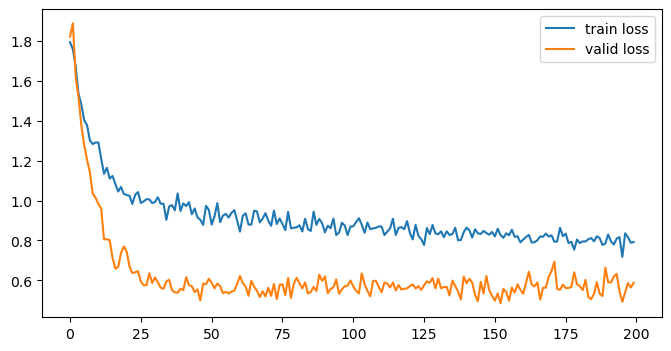

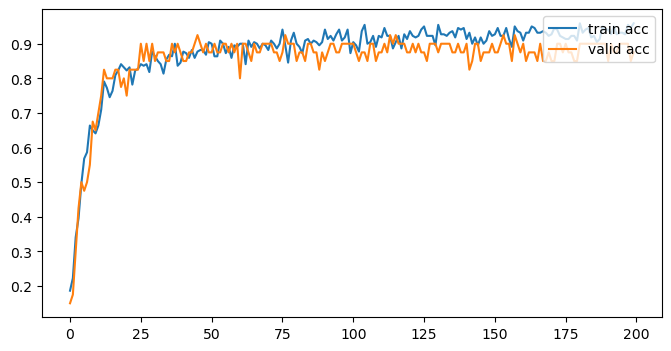

In [25]:
path = 'D:/Workspace/Teng-Signal-Classification/output/'

csv_file = path + 'train_loss' + '.csv'
img_file = path + 'train_loss' + '.jpg'
txt_file = path + 'set_slice' + '.txt'

epoch_scale = list(range(0, len(train_loss)))

plt.figure(figsize=(8, 4))
plt.plot(epoch_scale, train_loss, epoch_scale, valid_loss)
label = ['train loss', 'valid loss']
plt.legend(label, loc='upper right')
plt.savefig(path + 'loss.jpg')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epoch_scale, train_acc, epoch_scale, valid_acc)
label = ['train acc', 'valid acc']
plt.legend(label, loc='upper right')
plt.savefig(path + 'acc.jpg')
plt.show()

Data = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],

}

Data['train_loss'] = train_loss
Data['valid_loss'] = valid_loss
Data['train_acc'] = train_acc
Data['valid_acc'] = valid_acc

savedata = pd.DataFrame(data=Data)
savedata.to_csv(path + 'loss&acc.csv')


with open(txt_file, 'w') as f:
    f.write('train_set:')
    f.write(str(train_set))
    f.write('\n')
    f.write('\n')
    f.write('valid_set:')
    f.write(str(valid_set))
    f.write('\n')
    f.write('\n')
    f.write('test_set:')
    f.write(str(test_set))


## Load Trainer

In [26]:
trainer_path = 'D:/Workspace/TENG-Signal-Classification/trainer/'
device = torch.device("cpu")
cases = os.listdir(trainer_path)
trainers = []

for case in cases:
    state_dict = torch.load(trainer_path + case)
    trainers.append([case,state_dict])


In [27]:

criterion = torch.nn.CrossEntropyLoss() 
accuracy = Accuracy(task="multiclass", num_classes=6)
to_one_hot = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]
test_result = []

for i, trainer in enumerate(trainers):
    name, state = trainer
    lstm = LSTM(n_features, n_classes, n_hidden, n_layers, dropout, device)
    lstm.load_state_dict(state)
    _l_ = []
    _pre_ = []
    _p_ = []
    for index, case in enumerate(test_set):
        y = Y_test_tensors[index]
        one_hot = to_one_hot[y]
        
        outputs = lstm(X_test_tensors[index]) #forward pass
        step_loss = criterion(torch.unsqueeze(outputs,0), torch.unsqueeze(torch.FloatTensor(one_hot),0).to(device))
        _l_.append(step_loss.item())
         
        outputs = outputs.softmax(dim = 0)
        _p_.append(outputs)
        # 
        prediction = torch.argmax(outputs)
        # 
        _pre_.append(prediction)
    
    acc = accuracy(torch.tensor(_pre_), torch.tensor(Y_test_tensors))
    loss = np.mean(_l_)
    test_result.append([name,loss,acc])
Acc = []
for i, para in enumerate(test_result):
    ep, _, acc = para
    Acc.append(acc)

test_result[Acc.index(max(Acc))]


['epoch_105_loss_0.47341999374330046_acc_87.5%.pt',
 0.3698954664170742,
 tensor(0.9500)]

<Figure size 18000x18000 with 0 Axes>

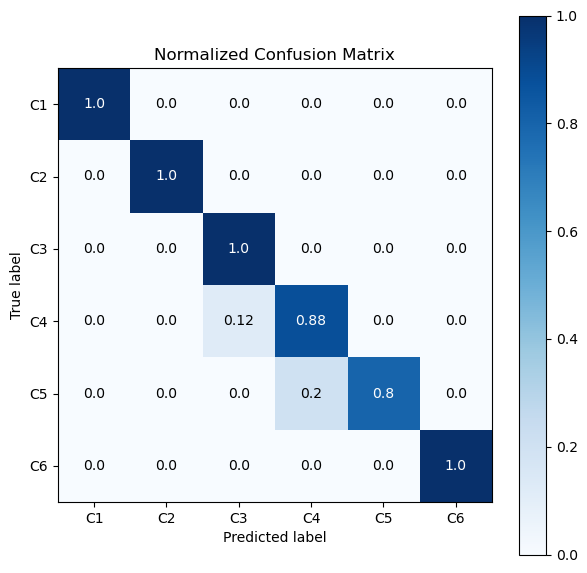

In [29]:
best_result_path = 'D:/Workspace/TENG-Signal-Classification/output/4/trainer/' + test_result[Acc.index(max(Acc))][0]
state_dict = torch.load(best_result_path)
lstm = LSTM(n_features, n_classes, n_hidden, n_layers, dropout, device)
lstm.load_state_dict(state_dict)
_l_ = []
_pre_ = []
_p_ = []
for index, case in enumerate(test_set):
    y = Y_test_tensors[index]
    one_hot = to_one_hot[y]
    
    outputs = lstm(X_test_tensors[index]) #forward pass
    step_loss = criterion(torch.unsqueeze(outputs,0), torch.unsqueeze(torch.FloatTensor(one_hot),0).to(device))
    _l_.append(step_loss.item())
     
    outputs = outputs.softmax(dim = 0)
    _p_.append(outputs)
    # 
    prediction = torch.argmax(outputs)
    # 
    _pre_.append(prediction)

acc = accuracy(torch.tensor(_pre_), torch.tensor(Y_test_tensors))
loss = np.mean(_l_)


path = 'D:/Workspace/TENG-Signal-Classification/output/'
plt.figure(figsize=(30, 30), dpi=600) #设置画布的大小和dpi，为了使图片更加清晰
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
pred_labels = []
true_labels = []

for i in _pre_:
    pred_labels.append(labels[i])
for i in Y_test_tensors:
    true_labels.append(labels[i])

skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, labels = labels,
                                    normalize=True, figsize = (7,7))
plt.savefig(path + 'confusion_matrix.png', format='png')
plt.show()